In [19]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random

print('Required version:')
print('     numpy  1.24.4')
print('     cv2 4.8.0')
print('     matplotlib 3.7.1')

print('Your current version:')
print('     numpy ', np.__version__)
print('     cv2', cv.__version__)
print('     matplotlib', plt.matplotlib.__version__)

In [20]:
# import the image
image1 = cv.imread('img/im01.jpg', cv.IMREAD_COLOR)
img1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)

image2 = cv.imread('img/im02.jpg', cv.IMREAD_COLOR)
img2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
in_imgs = np.hstack((image1, image2))

In [21]:
# while True:
#     cv.imshow('Input Images',input_images)
#     if cv.waitKey(1) == ord('q'):
#         break
#     # Release everything if job is finished
# cv.destroyAllWindows()
cv.imshow('press q to quit', in_imgs)
cv.waitKey(0)
cv.destroyWindow('press q to quit')
cv.waitKey(1)

-1

In [22]:
def sift_opera(i1, i2):
    if not i1.any() or not i2.any():
        raise ValueError('image is empty')

    if not (len(i1.shape) == 3):
        raise ValueError('image1 is not a RGB image')

    sift = cv.SIFT_create()

    i1 = cv.cvtColor(i1, cv.COLOR_BGR2GRAY)
    k1, dt1 = sift.detectAndCompute(i1, None)

    i2 = cv.cvtColor(i2, cv.COLOR_BGR2GRAY)
    k2, dt2 = sift.detectAndCompute(i2, None)

    if not dt2.any() or not dt1.any():
        raise ValueError('des1 or des2 is empty')

    def find_matches(d1, d2):
        if not (len(d1.shape) == 2):
            raise ValueError('des1 is not a matrix')
        if not (len(d2.shape) == 2):
            raise ValueError('des2 is not a matrix')
        [pd1, _] = d1.shape
        [pd2, _] = d2.shape

        m1 = []
        for i in range(0, pd1):
            dist = np.zeros([pd2, 1])
            for j in range(0, pd2):
                v = d1[i] - d2[j]
                dist[j] = np.dot(v, v.T)

            coords = np.argmin(dist)
            tp1 = int(dist[coords])
            m1.append(cv.DMatch(_imgIdx=0, _trainIdx=coords, _distance=tp1, _queryIdx=i))

        if not m1:
            raise ValueError('matches1 is empty')
        m2 = []
        for i in range(0, pd2):
            dist = np.zeros([pd1, 1])
            for j in range(0, pd1):
                v = d2[i] - d1[j]
                dist[j] = np.dot(v, v.T)

            coords = np.argmin(dist)
            tp1 = int(dist[coords])
            m2.append(cv.DMatch(_imgIdx=0, _trainIdx=coords, _distance=tp1, _queryIdx=i))

        if not m2:
            raise ValueError('matches2 is empty')

        matches = []
        for a in m1:
            for i in m2:
                if a.queryIdx == i.trainIdx and a.trainIdx == i.queryIdx:
                    matches.append(a)

        return matches

    matches = find_matches(dt1, dt2)
    if not matches:
        raise ValueError('matches is empty')
    min_matches = 8
    if len(matches) < min_matches:
        print('matches not enough')
        exit()
    return matches, k1, k2

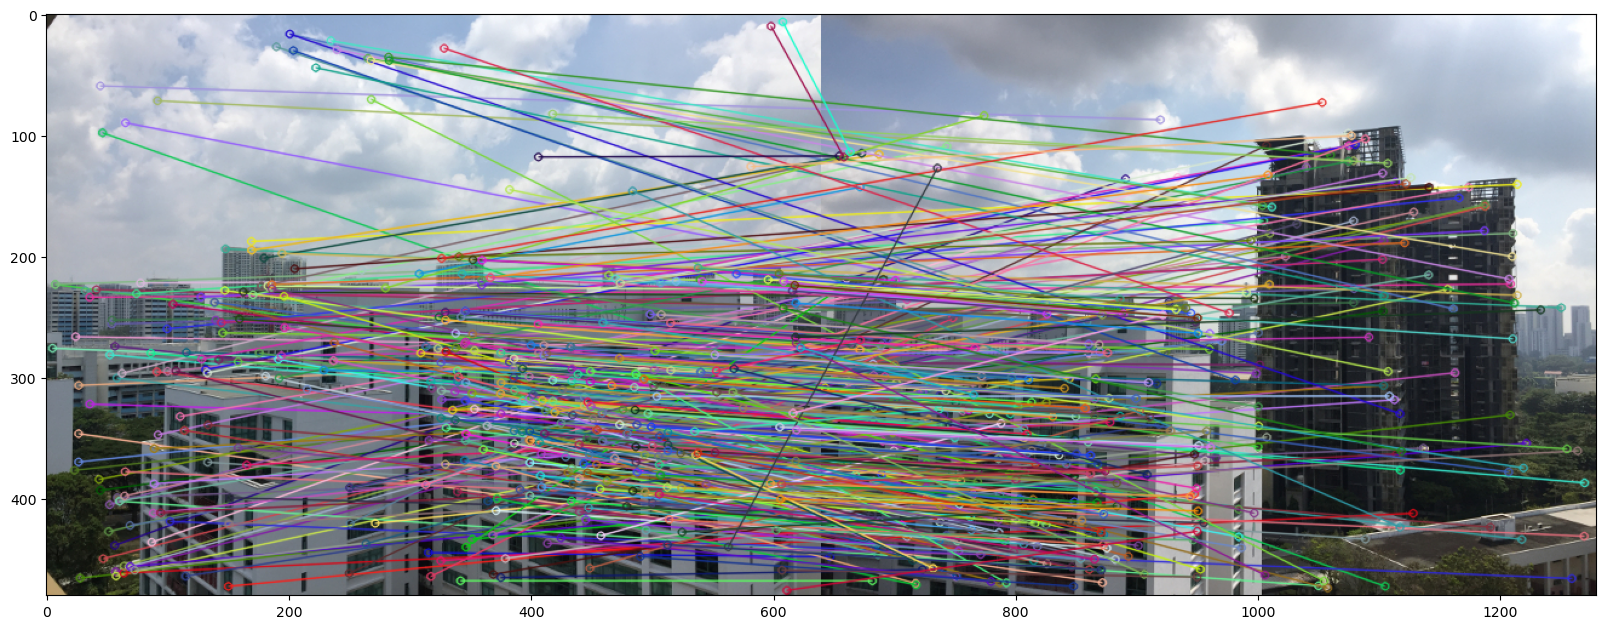

In [23]:
[km, k1, k2] = sift_opera(image1, image2)
res_matches = cv.drawMatches(img1, k1, img2, k2, km, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 20))
plt.imshow(res_matches)
plt.show()

In [24]:
def homography(points):
    if not points.any():
        raise ValueError('points is empty')
    row = len(points)
    n_mat = int(row / 2)
    mat = np.zeros([row, 9])

    for i in range(0, n_mat):
        x_h1, y_h1, x_h2, y_h2 = points[i][0], points[i][1], points[i + n_mat][0], points[i + n_mat][1]
        mat[2 * i][:] = [x_h1, y_h1, 1, 0, 0, 0, -x_h2 * x_h1, -x_h2 * y_h1, -x_h2]
        mat[2 * i + 1][:] = [0, 0, 0, x_h1, y_h1, 1, -y_h2 * x_h1, -y_h2 * y_h1, -y_h2]

    _, _, vt = np.linalg.svd(mat)
    H_res = vt[-1].reshape(3, 3)
    H_res = H_res / H_res[2, 2]

    return H_res


def ransac_h(k_1, k_2, matches, num_epochs):
    if not matches:
        raise ValueError('matches is empty')

    HH_res = []
    threshold = 1
    n_in = 0

    n_matches = len(matches)
    k1 = np.zeros([n_matches, 2])
    k2 = np.zeros([n_matches, 2])

    for i in range(n_matches):
        for j in range(2):
            k1[i, j] = k_1[matches[i].queryIdx].pt[j]
            k2[i, j] = k_2[matches[i].trainIdx].pt[j]

    mp = np.concatenate((k1, k2), axis=1)
    if not mp.any():
        raise ValueError('mp is empty')
    best_matched = []
    nums_points = 4

    def count_inliers(H, thresh, mp, matches):
        if not H.any():
            raise ValueError('H is empty')
        if not mp.any():
            raise ValueError('mp is empty')
        row = len(mp)
        p1 = mp[:, 0:2]
        p2 = mp[:, 2:4]

        x1 = np.concatenate((p1, np.ones([row, 1])), axis=1)
        x2 = np.dot(H, x1.T)
        # mask = x2[2, :] != 0  # mask for divide
        # x2[0:2, :] = np.divide(x2[0:2, :], x2[2, :], where=mask, out=np.zeros_like(x2[0:2, :]))
        epsilon = 1e-10  # avoid divide by zero
        x2[2, :] += epsilon  # add epsilon to avoid divide by zero
        x2[0:2, :] /= x2[2, :]  # divide by homogeneous coordinate

        # x2 = x2[0:2, :] / x2[2, :]
        es_p2 = x2[0:2, :].T
        if not es_p2.any():
            raise ValueError('es_p2 is empty')
        sub = p2 - es_p2
        sub_sq = sub * sub
        d = np.sqrt(np.sum(sub_sq, axis=1))
        # d = np.sqrt(sub_sq[:, 0] + sub_sq[:, 1])

        if not matches:
            raise ValueError('matches is empty')

        match = [m for d, m in zip(d, matches) if d < thresh]

        return match

    for i in range(0, num_epochs):
        samples = random.sample(range(0, n_matches), nums_points)
        points = np.array([[k1[samples[0]][0], k1[samples[0]][1]], [k1[samples[1]][0], k1[samples[1]][1]],
                           [k1[samples[2]][0], k1[samples[2]][1]], [k1[samples[3]][0], k1[samples[3]][1]],
                           [k2[samples[0]][0], k2[samples[0]][1]], [k2[samples[1]][0], k2[samples[1]][1]],
                           [k2[samples[2]][0], k2[samples[2]][1]], [k2[samples[3]][0], k2[samples[3]][1]]])

        H_res = homography(points)

        match = count_inliers(H_res, threshold, mp, matches)

        if len(match) > n_in:
            n_in = len(match)
            HH_res = H_res
            best_matched = match

    return HH_res, best_matched


while True:
    num_epochs = 100001
    HH_res, match_best = ransac_h(k1, k2, km, num_epochs)

    if len(match_best) > 0:
        break

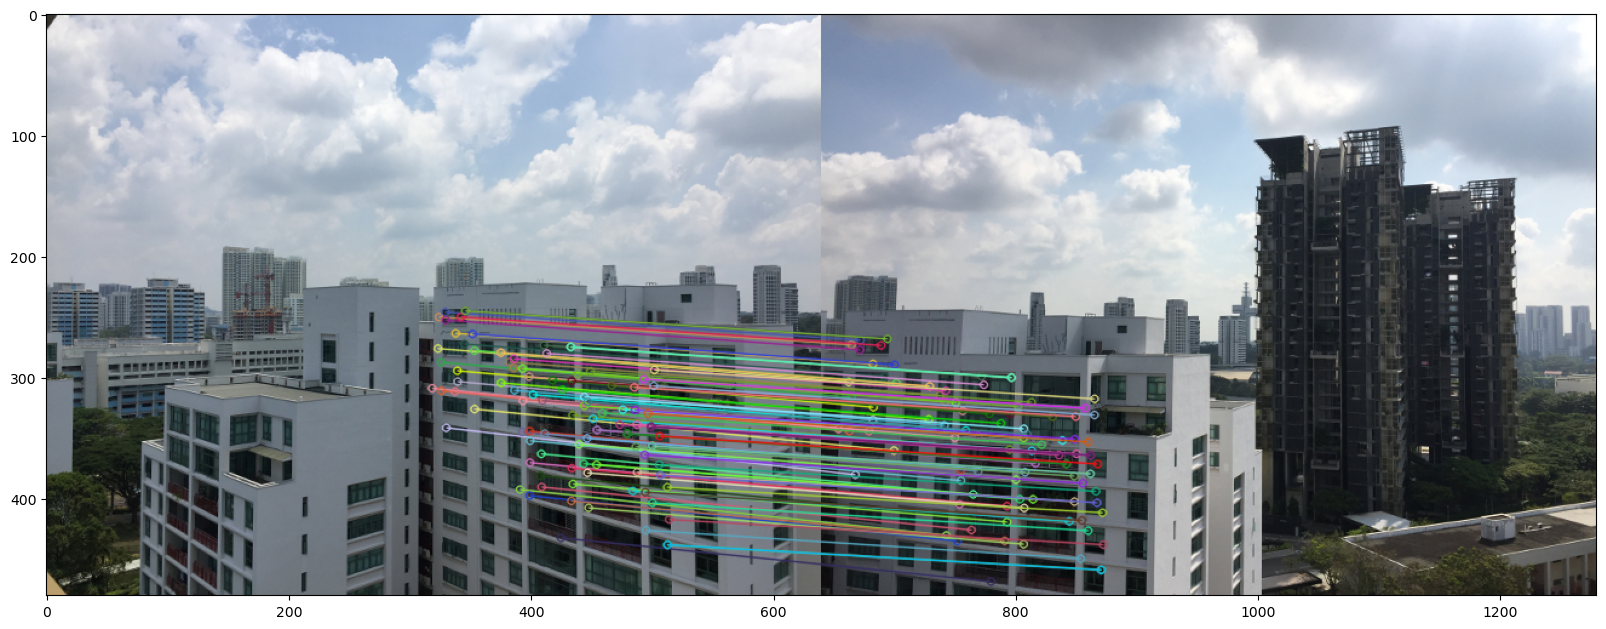

In [25]:
match_best_res = cv.drawMatches(img1, k1, img2, k2, match_best, None,
                                flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 20))
plt.imshow(match_best_res)
plt.show()

In [26]:
def build_canvas(img1, img2, H_i):
    if not (len(img1.shape) == 3 and len(img2.shape) == 3):
        raise ValueError('im1 or im2 is not a RGB image')

    [r1_val, c1_val, _] = img1.shape
    [_, _, cc] = img2.shape
    # 
    def size_shape(H, h1):
        if not h1.any():
            raise ValueError("h1 is None")
        if len(h1.shape) == 2:
            [r_val, c_val] = h1.shape
            cc = 1
        else:
            [r_val, c_val, cc] = h1.shape

        [r_val, c_val, cc] = h1.shape
        lt, rt, lb, rb = np.array([[0, 0, 1]]), np.array([[0, c_val, 1]]), np.array([[r_val, 0, 1]]), np.array(
            [[r_val, c_val, 1]])
        if cc == 1:
            lt = lt.T
            rt = rt.T
            lb = lb.T
            rb = rb.T
        edge = np.concatenate((lt, rt, lb, rb), axis=0).T
        if cc == 1:
            edge = edge.T
        e_trans = np.dot(H, edge)
        e_trans = e_trans[0:2, :] / e_trans[2, :]
        return np.max(e_trans[0, :]), np.min(e_trans[0, :]), np.max(e_trans[1, :]), np.min(e_trans[1, :])

    [x_max, x_min, y_max, y_min] = size_shape(H_i, img2)

    sub = 1

    x_sub = int(np.min([0, x_min]) - sub)
    x_add = int(np.max([0, x_max - r1_val]) + sub)
    y_sub = int(np.min([0, y_min]) - sub)
    y_add = int(np.max([0, y_max - c1_val]) + sub)

    px_sub = np.zeros([-x_sub, c1_val, cc])
    px_add = np.zeros([x_add, c1_val, cc])

    if not (len(px_sub.shape) == 3 and len(px_add.shape) == 3):
        raise ValueError('add_x_minus or add_x_plus is not a RGB image')

    py_sub = np.zeros([-x_sub + r1_val + x_add, -y_sub, cc])
    py_add = np.zeros([-x_sub + r1_val + x_add, y_add, cc])
    # if not (len(py_sub.shape) == 3 and len(py_add.shape) == 3):
    #     raise ValueError('add_y_minus or add_y_plus is not a RGB image')
    cas = np.concatenate((px_sub, img1, px_add), axis=0)
    cas = np.concatenate((py_sub, cas, py_add), axis=1)

    return cas.astype(int), [x_sub, y_sub]


def trans_im22im1(comp, H_i, cas, im2):
    if not (len(cas.shape) == 3 and len(im2.shape) == 3):
        raise ValueError('canvas or im2 is not a RGB image')
    w = 0.618
    sps = 2
    [r_val, c_val, _] = im2.shape
    if not (len(comp) == 2):
        raise ValueError('compensation is not a 2D vector')
    for i in range(0, r_val * sps):
        for j in range(0, c_val * sps):
            pos = np.array([[i / sps, j / sps, 1]]).T
            trans_p = np.dot(H_i, pos)

            x1 = int(i / sps)
            y1 = int(j / sps)

            x2 = int(round(trans_p[0, 0] / trans_p[2, 0]) - comp[0])

            y2 = int(round(trans_p[1, 0] / trans_p[2, 0]) - comp[1])

            if np.any(cas[x2, y2] > 0):
                cas[x2, y2] = w * cas[x2, y2][:] + (1 - w) * im2[x1, y1][:]
            else:
                cas[x2, y2] = im2[x1, y1][:]

    return cas.astype(int)


# Interpolation process to fill the blank
def interpolation(image, size):
    if not image.any():
        raise ValueError('image is empty')

    if not (len(image.shape) == 3):
        raise ValueError('image is not a RGB image')
    [row, col, c] = image.shape
    valid_pixels = image[~np.isnan(image)]  # catch the valid pixels
    default_val = int(np.mean(valid_pixels)) if valid_pixels.size else 0  # compute the mean of valid pixels
    for j in range(0, row):
        for k in range(0, col):
            if np.all(np.isnan(image[j, k]) | (image[j, k] == 0)):  # check if NaN or 0
                for n in range(0, c):
                    r_start, r_end = max(j - size, 0), min(j + size + 1, row)
                    c_start, c_end = max(k - size, 0), min(k + size + 1, col)

                    sub_array = image[r_start:r_end, c_start:c_end, n]
                    avg_val = np.nanmean(sub_array)  # use np.nanmean to ignore NaN values

                    if np.isnan(avg_val):  # if NaN，use default value
                        avg_val = default_val

                    image[j, k, n] = int(avg_val)

    return image


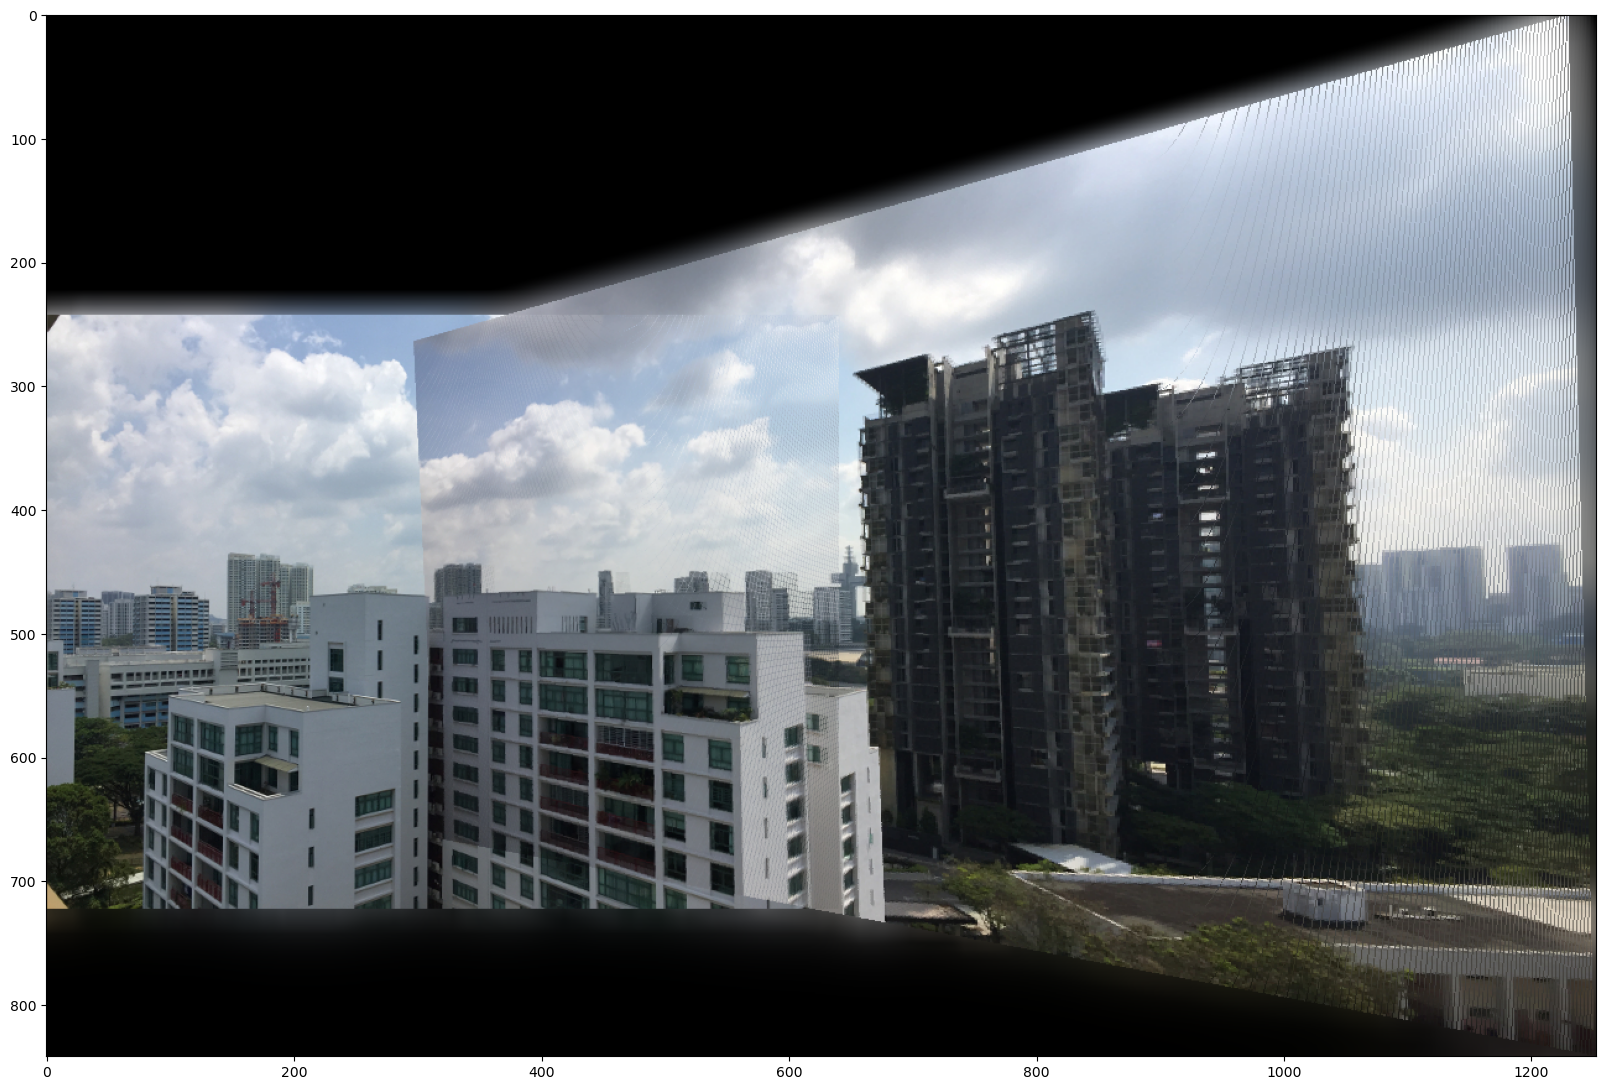

In [27]:
num_m = len(match_best)
i_1 = np.zeros([num_m, 2])
i_2 = np.zeros([num_m, 2])

for i in range(num_m):
    for _ in range(2):
        i_1[i] = [k1[match_best[i].queryIdx].pt[1], k1[match_best[i].queryIdx].pt[0]]
        i_2[i] = [k2[match_best[i].trainIdx].pt[1], k2[match_best[i].trainIdx].pt[0]]

ips = np.concatenate((i_1, i_2), axis=0)
ips_h = homography(ips)
H_i = np.linalg.inv(ips_h)
canvas, compensation = build_canvas(img1, img2, H_i)
tr1 = trans_im22im1(compensation, H_i, canvas, img2)
tr_inter = interpolation(tr1, 20)
plt.figure(figsize=(20, 20))
plt.imshow(tr_inter)